> To run this model, you can use Google Colab with a T4 GPU or a Kaggle Notebook with a T4x2 GPU

In [ ]:
!pip install git+https://github.com/huggingface/transformers
!pip install qwen-vl-utils
!pip install faiss-cpu

In [15]:
from PIL import Image
import matplotlib.pyplot as plt

def show_image(img):
    img = Image.open(img)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

# I.Image Based Description

In this chapter, we will download the Qwen2.5 VL 2B model and use it to generate descriptions for uploaded images.

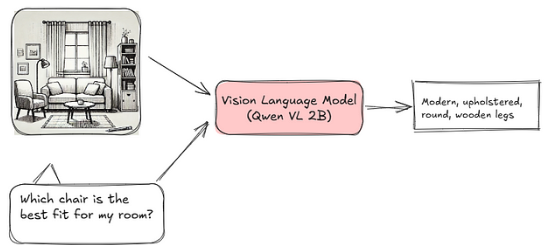

In [4]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info, fetch_image, extract_vision_info
import torch

## 1.Load Model

In [ ]:
model_name = "Qwen/Qwen2-VL-2B-Instruct"
qwen_model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

qwen_processor = AutoProcessor.from_pretrained(model_name, min_pixels=256*28*28, max_pixels=1024*28*28)

In [6]:
def generate_text_from_image(image_path, text, model, processor):
    """
    Generates text from an image and a given prompt using the Qwen2.5 VL model.

    Args:
        image_path (str): Path to the input image.
        text (str): Text prompt/question for the model.
        model: Preloaded  Qwen2.5 VL model.
        processor: Corresponding processor for DeepSeek-VL2.

    Returns:
        str: The generated text response.
    """

    # Prepare the input messages (conversation format)
    messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image_path,
            },
            {"type": "text", "text": text},
        ],
    }
    ]

    # Apply chat template formatting
    formatted_text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    # Process images and prepare inputs
    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[formatted_text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    # Model inference
    generated_ids = model.generate(**inputs, max_new_tokens=128)

    # Trim generated tokens
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

    # Decode the output
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return as a single string

## 2.Generate Text

In this section, we will load an image of a living room and use the Qwen VL model to determine the best-fitting chair for the space.

In [7]:
# If you are storing images in Google Drive, use this code to sync with it.
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
living_room_image = "<INPUT IMAGE PATH AT HERE>/living_room.png"

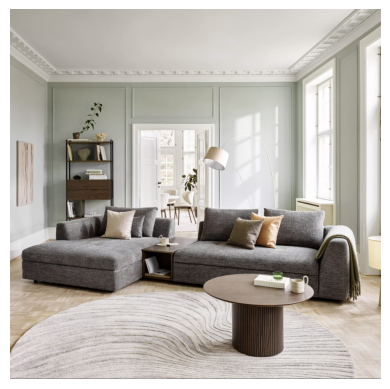

In [16]:
prompt = """
I’m going to buy a chair for my house.
Describe which chair would best fit the style of the room, keep your answer as short as possible,
only providing color, material, style, shape
"""

show_image(living_room_image)

chair_describe = generate_text_from_image(living_room_image, prompt, qwen_model, qwen_processor)

In [11]:
print(chair_describe)

Modern, upholstered, round, wooden legs


# II.Product Retrieval

Next, we will set up a RAG system for storage products. This demo includes 18 furniture images, featuring different chairs and cabinets.

- In **prepareration session**, we load the CLIP model to convert images into embedding vectors and store them in a vector database.

- Then, at **retrieval session**, we retrieve the product that best matches the description from the first step.

----------

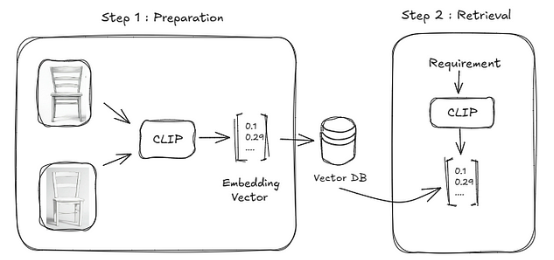

## 1.Preparation

In [31]:
from transformers import CLIPProcessor, CLIPModel, AutoModelForCausalLM
import os
import numpy as np
import faiss

**Step 1: Load CLIP Models**

In [ ]:
model_id = "openai/clip-vit-base-patch32"

clip_processor = CLIPProcessor.from_pretrained(model_id)
clip_model = CLIPModel.from_pretrained(model_id).to("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
def calculate_embedding(text, image_path=None):
    """Calculate text and image embeddings using the CLIP model."""
    image = Image.open(image_path) if image_path else None

    device = "cuda" if torch.cuda.is_available() else "cpu"
    inputs = clip_processor(text=text, images=image, return_tensors="pt", padding=True).to(device)

    # Ensure pixel_values exist to prevent errors
    if "pixel_values" not in inputs:
        inputs["pixel_values"] = torch.zeros(1, 3, 224, 224, device=inputs.input_ids.device)

    with torch.no_grad():
        outputs = clip_model(**inputs)

    return outputs.image_embeds, outputs.text_embeds

**Step 2: Prepare Images, Create VectorDB**

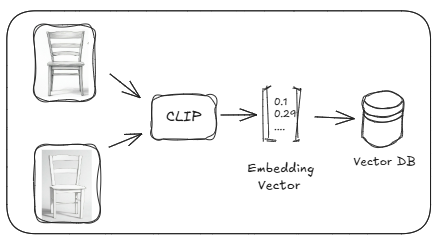

In [32]:
def create_faiss_index_from_images(image_files):
    """
    Calculates embeddings for a list of image files and creates a FAISS index.

    Args:
        image_files (list): List of image file paths.

    Returns:
        faiss.IndexFlatL2: FAISS index containing image embeddings.
        list: List of corresponding image paths.
    """
    all_image_embeddings = []
    all_image_paths = []

    for image_file in image_files:
        image_embedding, _ = calculate_embedding("", image_file)
        all_image_embeddings.append(image_embedding.cpu().detach().numpy().reshape(1, -1))
        all_image_paths.append(image_file)

    # Convert to NumPy array and create FAISS index
    image_embeddings_np = np.concatenate(all_image_embeddings, axis=0).astype('float32')
    d = image_embeddings_np.shape[1]
    vector_db = faiss.IndexFlatL2(d)
    vector_db.add(image_embeddings_np)

    # Attach image paths to the index
    vector_db.image_paths = all_image_paths

    return vector_db, all_image_paths

In [33]:
image_folder = '<INPUT FURNITURE IMAGES PATH AT HERE>'
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

vector_db, all_image_paths = create_faiss_index_from_images(image_files)

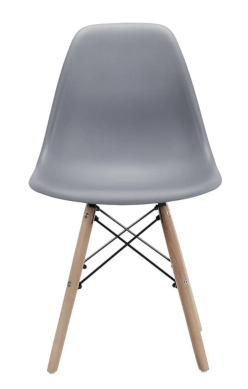

In [34]:
show_image(image_files[0])

## 2.Retrieval

In [35]:
print(chair_describe)

Modern, upholstered, round, wooden legs


In [38]:
def retrieve_similar_images(text=None, top_k=2):
    """
    Retrieve the top-k most similar images based on text or image input.

    Args:
        text (str, optional): Query text.
        top_k (int): Number of similar images to retrieve.

    Returns:
        list: List of tuples containing image paths and similarity scores.
    """
    _, embedding = calculate_embedding(text=text, image_path=None)
    query_embedding = embedding.cpu().detach().numpy().reshape(1, -1).astype('float32')

    # Perform the search
    distances, indices = vector_db.search(query_embedding, top_k)

    # Retrieve image paths and normalize similarity scores
    return [(vector_db.image_paths[idx], 1 - dist / 2) for idx, dist in zip(indices[0], distances[0])]


Image Path: /content/drive/MyDrive/10_Udemy_Couse2/01_Lab/Utils/furnitures/chair3.png, Similarity Score: 0.3143061399459839


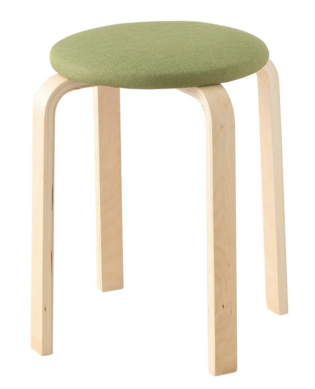

Image Path: /content/drive/MyDrive/10_Udemy_Couse2/01_Lab/Utils/furnitures/chair7.png, Similarity Score: 0.31268560886383057


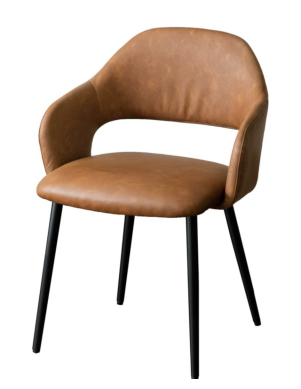

In [39]:
retrieved_images = retrieve_similar_images(text=chair_describe)

for img_path, score in retrieved_images:
    print(f"Image Path: {img_path}, Similarity Score: {score}")
    show_image(img_path)